In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Ubicación en drive de la data

In [2]:
#changing the working directory
%cd /content/drive/My Drive/Kaggle
#Check the present working directory using pwd command
!ls

/content/drive/My Drive/Kaggle
acf.eps		   EKPC_hourly.csv		  pjm_hourly_est.csv
AEP_hourly.csv	   est_hourly.paruqet		  PJM_Load_hourly.csv
COMED_hourly.csv   FE_hourly.csv		  PJMW_hourly.csv
data.eps	   hourly-energy-consumption.zip  raw_data.eps
data.PNG	   kaggle.json			  rawData.eps
DAYTON_hourly.csv  logs				  rawData.PNG
DEOK_hourly.csv    LSTM.eps			  SARIMA.eps
DOM_hourly.csv	   NI_hourly.csv
DUQ_hourly.csv	   PJME_hourly.csv


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='IPAGothic')
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from google.colab import files

#Limpieza y orden de los datos

In [4]:
df = pd.read_csv('DOM_hourly.csv')

#Formato de fecha para la columna Datetime
df['Datetime'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['Datetime']]

#Si hay fechas (horas) repetidas, ocupar promedio
df = df.groupby('Datetime', as_index=False)['DOM_MW'].mean()

#Ordenar por fecha
df.sort_values('Datetime', inplace=True)

#Datetime como índice
df.set_index('Datetime', drop=True, append=False, inplace=True)

df

,DOM_MW
Datetime,
2005-05-01 01:00:00,7190.0
2005-05-01 02:00:00,6803.0
2005-05-01 03:00:00,6583.0
2005-05-01 04:00:00,6452.0
2005-05-01 05:00:00,6445.0
...,...
2018-08-02 20:00:00,14038.0
2018-08-02 21:00:00,13832.0
2018-08-02 22:00:00,13312.0


## OJO: 2005-05-01 tiene una hora menos de data, y 2018-08-03 tiene 23 horas menos de data

In [5]:
#Resampleo resolución diaria (suma horaria en un día)
dfDay = df.resample('D').sum()

#Se eliminan días con cantidad de horas (datos) menores a 24
dfDay.drop(pd.Timestamp('2018-08-03'),inplace = True)
dfDay.drop(pd.Timestamp('2005-05-01'),inplace = True)

## Separación TRAIN:VALIDATION:TEST

In [6]:
trainDay = dfDay.loc['2005':'2016']
trainValDay = dfDay['2005':'2017']

#Se consideran 7 días antes para la predicción del primer valor
valDay = dfDay['2016-12-25':'2017']
testDay = dfDay['2017-12-25':'2018']

findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

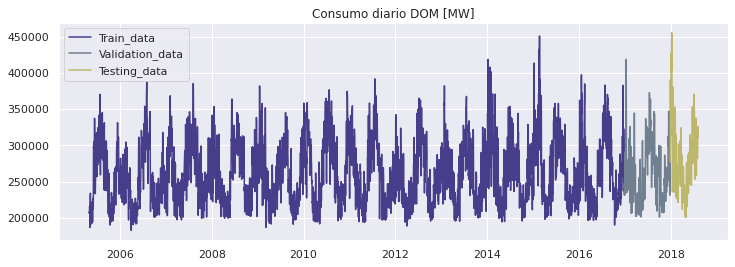

In [7]:
fig = plt.figure(figsize=(12, 4))
plt.plot(trainDay,label='Train_data',color = 'darkslateblue')
plt.plot(valDay,label='Validation_data',color = 'slategrey')
plt.plot(testDay,label='Testing_data',color = 'darkkhaki')
plt.title('Consumo diario DOM [MW]')
plt.legend()
#Memo; do not show the figure before saving
#plt.show()

#plt.savefig("data.eps")
#files.download("data.eps")

##Observación componentes de la onda. 

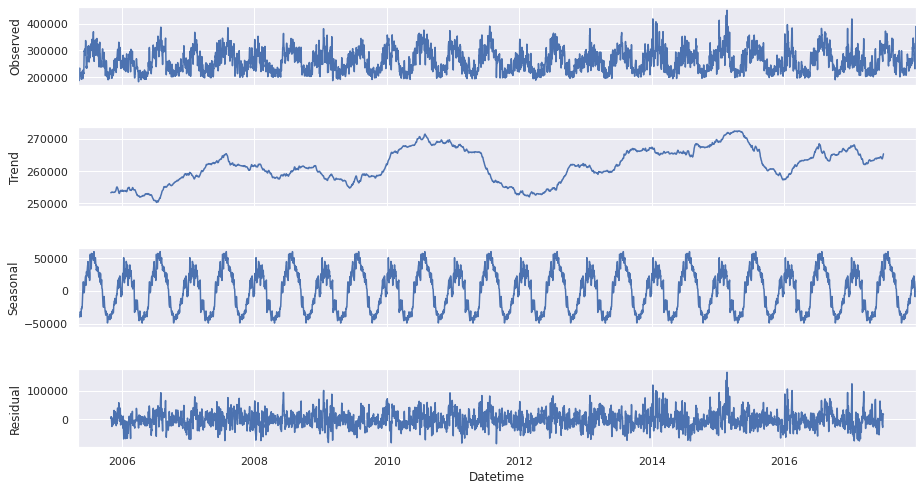

In [ ]:
res = sm.tsa.seasonal_decompose(trainValDay,freq=365)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

##Se observa estacionalidad, por lo tanto no es estacionaria (por inspección). Tendencia oscila.

In [ ]:
tr_start,tr_end = '2005-05-02','2016-12-31'
val_start,val_end = '2017-01-01','2017-12-31'
trVal_start,trVal_end = tr_start,val_end
tes_start,tes_end = '2018-01-01','2018-08-02'

In [ ]:
#ADF-test(Original-time-series)
res = sm.tsa.adfuller(trainValDay['DOM_MW'],regression='c')
print('p-value:{} c'.format(res[1]))

res = sm.tsa.adfuller(trainValDay['DOM_MW'],regression='ct')
print('p-value:{} ct'.format(res[1]))

#ADF-test(Original-time-series)
res = sm.tsa.adfuller(trainValDay['DOM_MW'],regression='c')
print('p-value:{} c'.format(res[1]))

res = sm.tsa.adfuller(trainValDay['DOM_MW'],regression='ct')
print('p-value:{} ct'.format(res[1]))

res = sm.tsa.adfuller(valDay['DOM_MW'],regression='ct')
print('p-value:{} c'.format(res[1]))

res = sm.tsa.adfuller(valDay['DOM_MW'],regression='ct')
print('p-value:{} ct'.format(res[1]))

p-value:1.1051223605196762e-11 c
p-value:2.551068655213205e-10 ct
p-value:1.1051223605196762e-11 c
p-value:2.551068655213205e-10 ct
p-value:0.15595696449578889 c
p-value:0.15595696449578889 ct


## Se confirma no estacionalidad de datos por los p valores de validación mayores a 5%, no pasa el test ADFuller. Además sabemos que la data tiene componente estacional, por lo tanto aplicamos una diferencia: Modelo I, d = 1.

No analizamos test data por que en teoría no la conocemos

## Se observa la autocorrelación de la variable y con tiempos anteriores

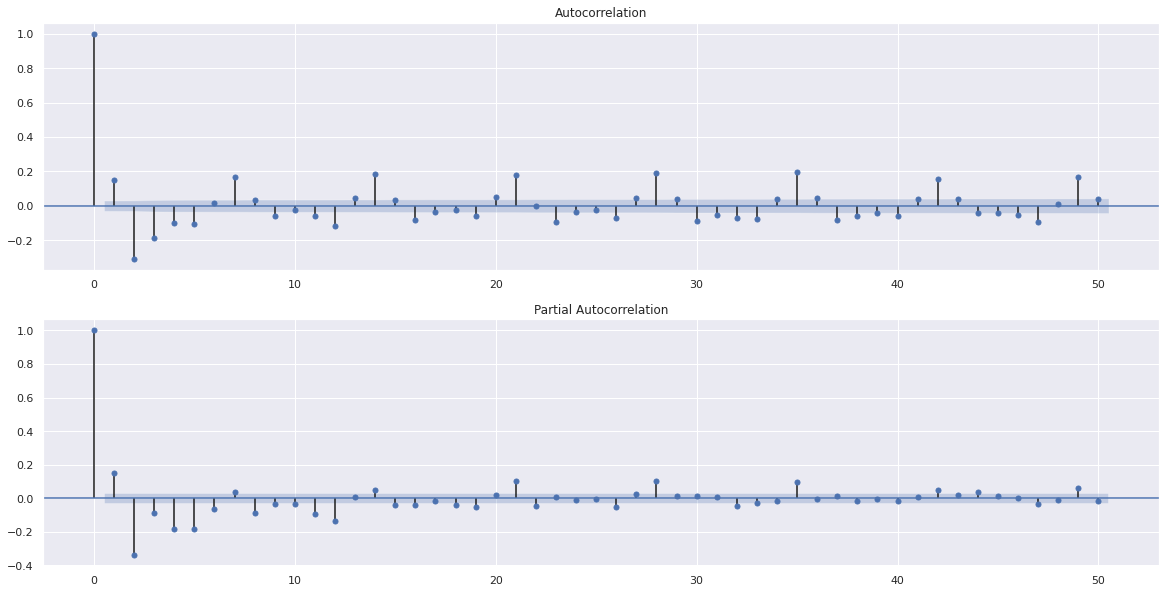

In [ ]:
#we use tra.diff()(differenced data), because this time series is unit root process.

fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(trainDay.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(trainDay.diff().dropna(), lags=50, ax=ax[1])
plt.show()

## De aquí se extra la clara correlación semanal, por lo tanto (y por limitaciones computacionales) se propone como adivinanza educada un valor S = 7

## Se buscan los menores valores AIC para los candidatos a mejores hiperparámetros del modelo. Se tomarán los que estén dentro del 5% menor del grupo AIC (3x1x3x3x2x3)= 8 menores.

In [ ]:
import itertools

p = q = [0,1,2]
ds = [0,1]
d = [1]
pdq = list(itertools.product(p, d, q))
pdsq = list(itertools.product(p, ds, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, ds, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(trainDay,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 1, 0)x(0, 0, 0, 7) - AIC:96809.0257012583
ARIMA(0, 1, 0)x(0, 0, 1, 7) - AIC:96566.50953771488
ARIMA(0, 1, 0)x(0, 0, 2, 7) - AIC:96336.94762007432
ARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC:98832.29231413009
ARIMA(0, 1, 0)x(0, 1, 1, 7) - AIC:96121.18847094977
ARIMA(0, 1, 0)x(0, 1, 2, 7) - AIC:95927.64579387399
ARIMA(0, 1, 0)x(1, 0, 0, 7) - AIC:96559.97186315313
ARIMA(0, 1, 0)x(1, 0, 1, 7) - AIC:96107.2593996935
ARIMA(0, 1, 0)x(1, 0, 2, 7) - AIC:95927.00862372355
ARIMA(0, 1, 0)x(1, 1, 0, 7) - AIC:97409.02168137085
ARIMA(0, 1, 0)x(1, 1, 1, 7) - AIC:96099.34883688942
ARIMA(0, 1, 0)x(1, 1, 2, 7) - AIC:95837.6221030146
ARIMA(0, 1, 0)x(2, 0, 0, 7) - AIC:96295.81288807976
ARIMA(0, 1, 0)x(2, 0, 1, 7) - AIC:95942.80477251753
ARIMA(0, 1, 0)x(2, 0, 2, 7) - AIC:95862.20221812344
ARIMA(0, 1, 0)x(2, 1, 0, 7) - AIC:96743.3950930951
ARIMA(0, 1, 0)x(2, 1, 1, 7) - AIC:95932.09977107955
ARIMA(0, 1, 0)x(2, 1, 2, 7) - AIC:95832.34149574311
ARIMA(0, 1, 1)x(0, 0, 0, 7) - AIC:96561.74635138208
ARIMA(0, 1, 1)x(

In [ ]:
def MAPE(real:list,forecast:list):
  
  n = len(forecast)
  S = 0
  for i in range(n):
    S+=np.abs(forecast[i] - real[i])/np.abs(real[i])
  M = S/n*100
  #print('MAPE = {}%'.format(MAPE))
  return M

## Obtenemos cada uno de los parámetros ajustados con el vector train, para probarlos con el vector de validación y obtener MAPE

In [ ]:
#Hiper parámetros a probar:

#1.- ARIMA(1, 1, 2)x(2, 0, 2, 7) - AIC:95159.45498195656
#2.- ARIMA(2, 1, 2)x(1, 0, 2, 7) - AIC:95204.9510215038
#3.- ARIMA(2, 1, 1)x(2, 0, 1, 7) - AIC:95292.79370698147
#4.- ARIMA(2, 1, 1)x(2, 0, 2, 7) - AIC:95250.32397693206
#5.- ARIMA(1, 1, 2)x(2, 0, 1, 7) - AIC:95266.34894315715
#6.- ARIMA(1, 1, 2)x(1, 0, 2, 7) - AIC:95220.40131907877
#7.- ARIMA(2, 1, 1)x(1, 0, 2, 7) - AIC:95302.69762976833
#8.- ARIMA(2, 1, 0)x(2, 0, 2, 7) - AIC:95353.2282487708


#predicción a un paso

##1.- (1,1,2)x(2,0,2,7)


95159.45498195656
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 7)   Log Likelihood              -47571.727
Date:                           Sun, 09 Aug 2020   AIC                          95159.455
Time:                                   19:51:23   BIC                          95210.281
Sample:                               05-02-2005   HQIC                         95177.417
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4369      0.025     17.166      0.000       0.387       0.487
ma.L1         -0.3387    

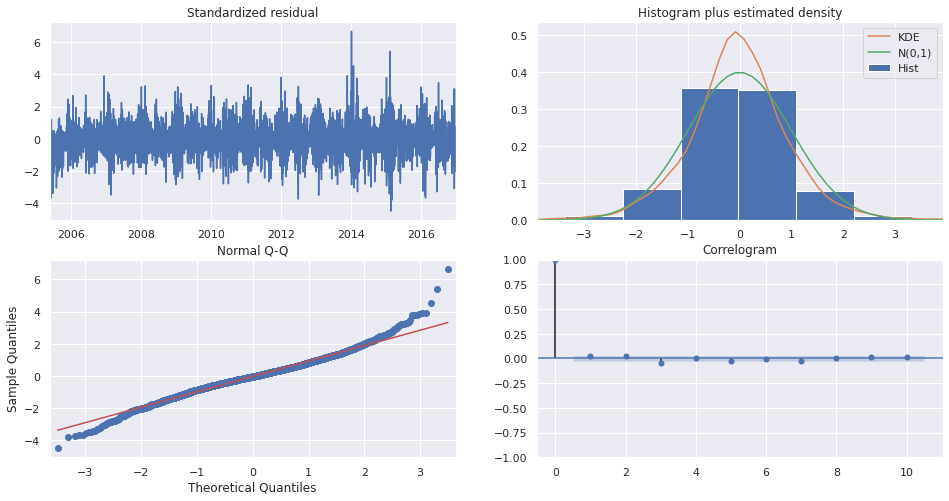

In [ ]:
mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(1, 1, 2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()


## Predecimos a un paso con los parámetros que obtuvimos de train sobre validación.

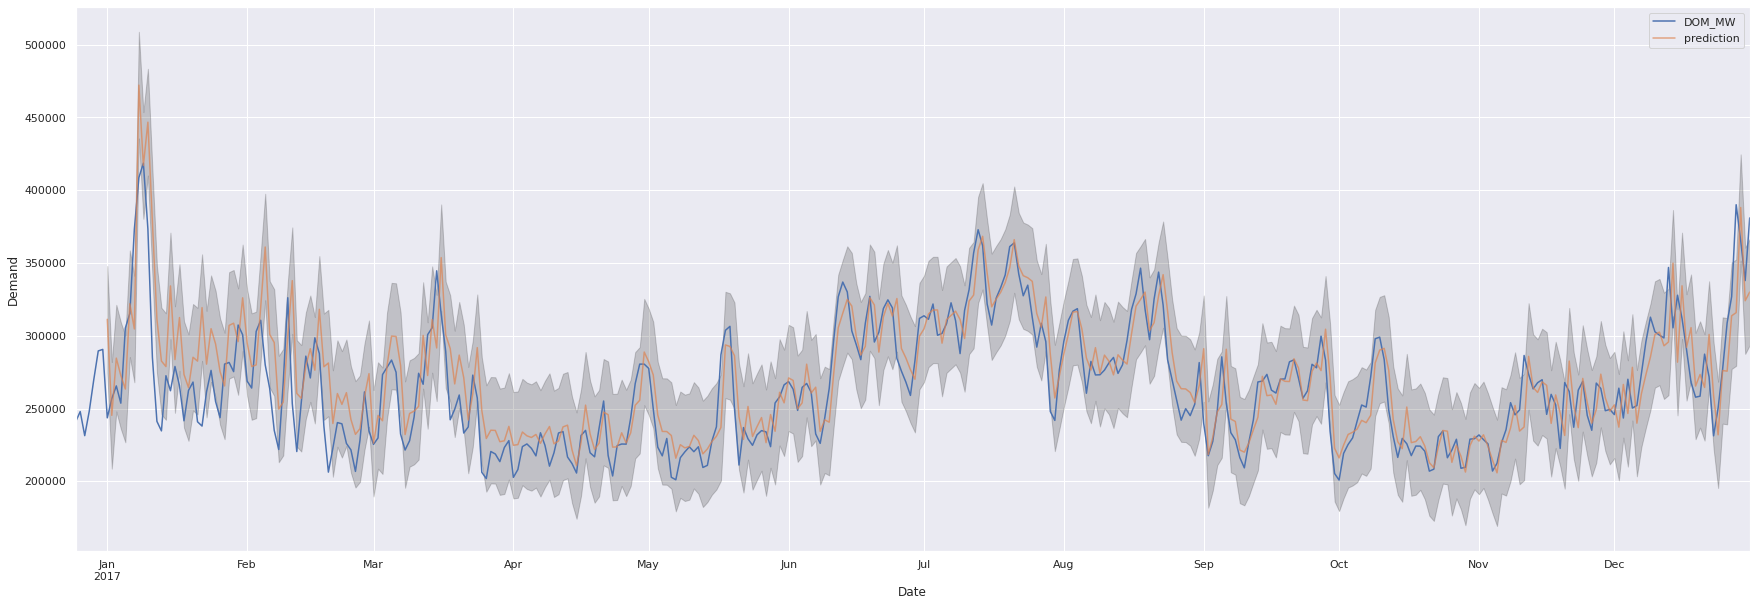

6.538602324073092

In [ ]:
mod = sm.tsa.statespace.SARIMAX(valDay,
                                order=(1, 1, 2),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=val_start, end=val_end, dynamic=False)
pred_ci = pred.conf_int()
ax = valDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(valDay['2017']['DOM_MW'],pred.predicted_mean)
Error

##2.- (2,1,2)x(1,0,2,7)

95204.9510215038
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(2, 1, 2)x(1, 0, 2, 7)   Log Likelihood              -47594.476
Date:                           Sun, 09 Aug 2020   AIC                          95204.951
Time:                                   19:54:30   BIC                          95255.777
Sample:                               05-02-2005   HQIC                         95222.913
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5627      0.032     17.355      0.000       0.499       0.626
ar.L2         -0.1523     

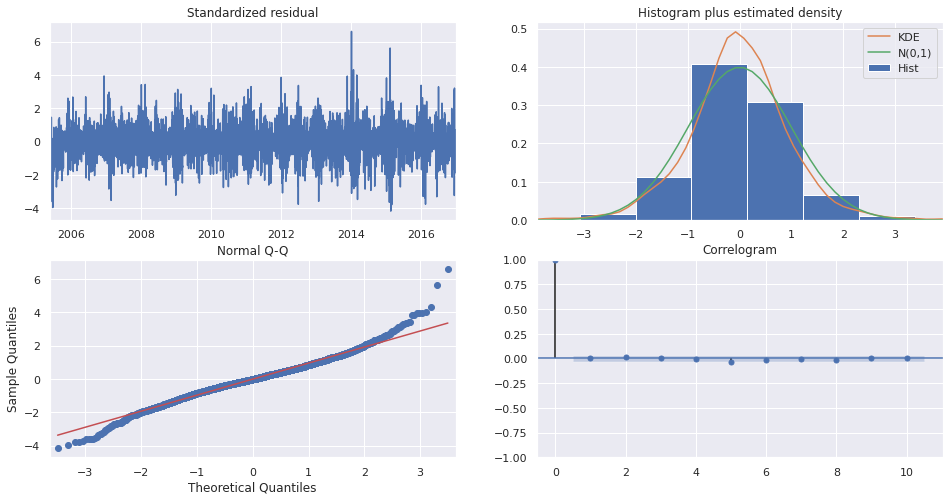

In [ ]:
#ARIMA(2, 1, 2)x(1, 0, 2, 7) - AIC:95204.9510215038

mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(2, 1, 2),
                                seasonal_order=(1, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

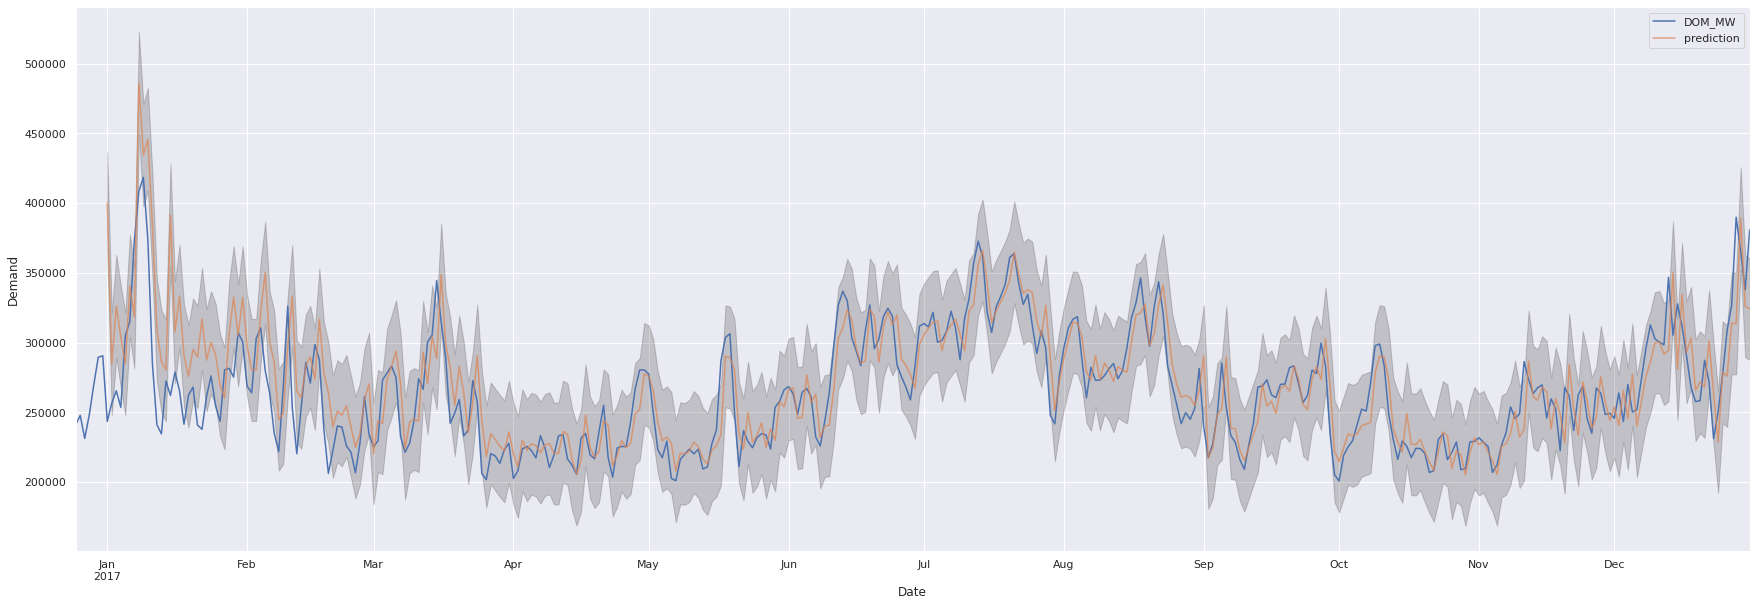

6.596291720723863

In [ ]:
mod = sm.tsa.statespace.SARIMAX(valDay,
                                order=(2, 1, 2),
                                seasonal_order=(1, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=val_start, end=val_end, dynamic=False)
pred_ci = pred.conf_int()
ax = valDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(valDay['2017']['DOM_MW'],pred.predicted_mean)
Error

##3.- (2,1,1)x(2,0,1,7)

95292.79370698147
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(2, 1, 1)x(2, 0, 1, 7)   Log Likelihood              -47639.397
Date:                           Sun, 09 Aug 2020   AIC                          95292.794
Time:                                   19:55:29   BIC                          95337.268
Sample:                               05-02-2005   HQIC                         95308.511
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7686      0.022     35.381      0.000       0.726       0.811
ar.L2         -0.3691    

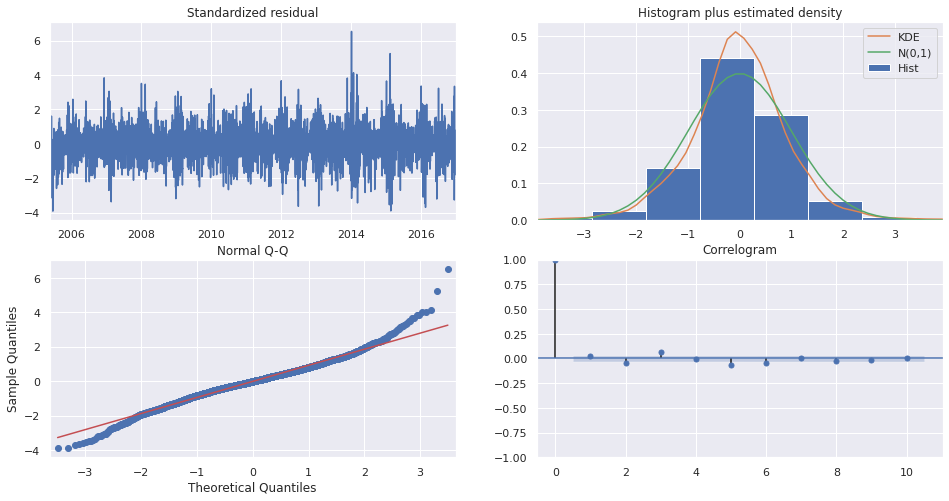

In [ ]:
#ARIMA(2, 1, 1)x(2, 0, 1, 7) - AIC:95292.79370698147

mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(2, 1, 1),
                                seasonal_order=(2, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

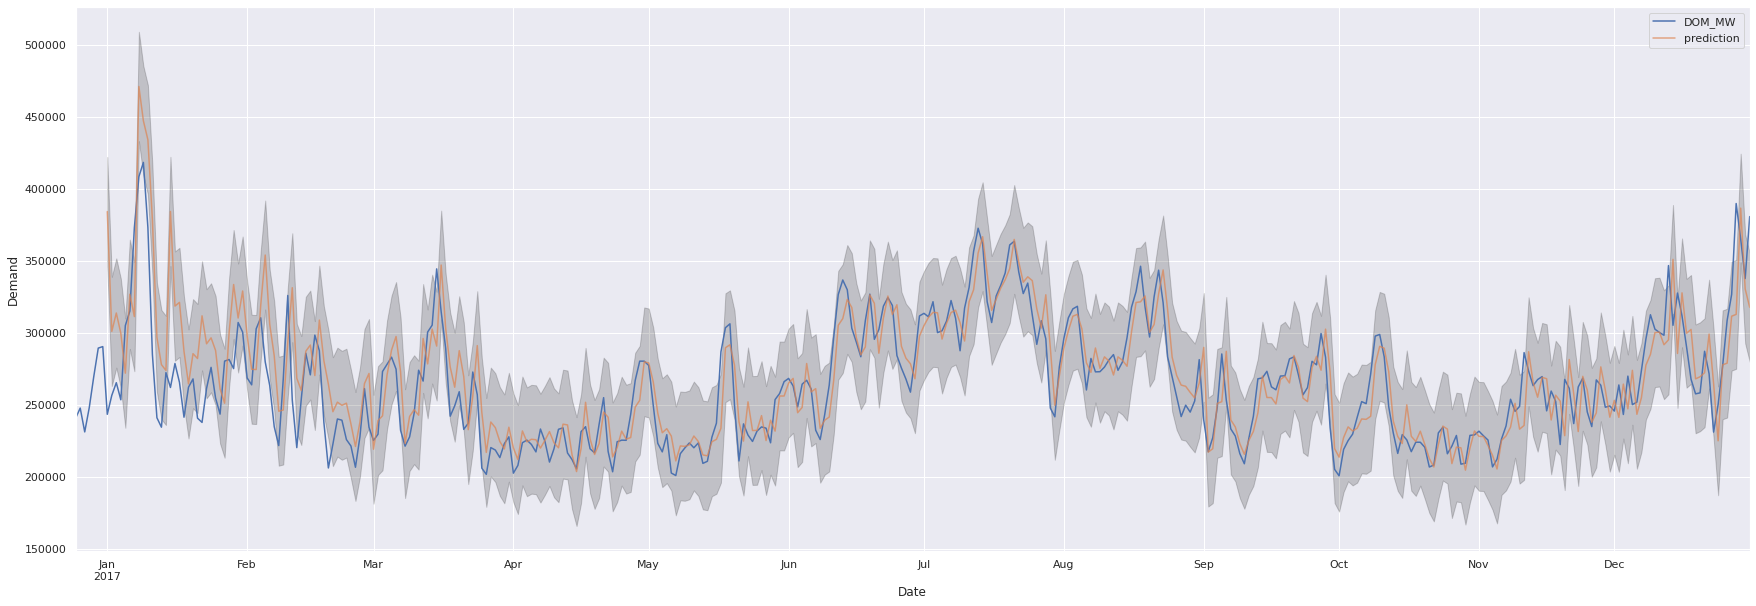

6.582602043043861

In [ ]:
mod = sm.tsa.statespace.SARIMAX(valDay,
                                order=(2, 1, 1),
                                seasonal_order=(2, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=val_start, end=val_end, dynamic=False)
pred_ci = pred.conf_int()
ax = valDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(valDay['2017']['DOM_MW'],pred.predicted_mean)
Error

##4.- (2,1,1)x(2,0,2,7)

95250.32397693206
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(2, 1, 1)x(2, 0, 2, 7)   Log Likelihood              -47617.162
Date:                           Sun, 09 Aug 2020   AIC                          95250.324
Time:                                   19:57:03   BIC                          95301.152
Sample:                               05-02-2005   HQIC                         95268.287
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7627      0.023     33.808      0.000       0.718       0.807
ar.L2         -0.3663    

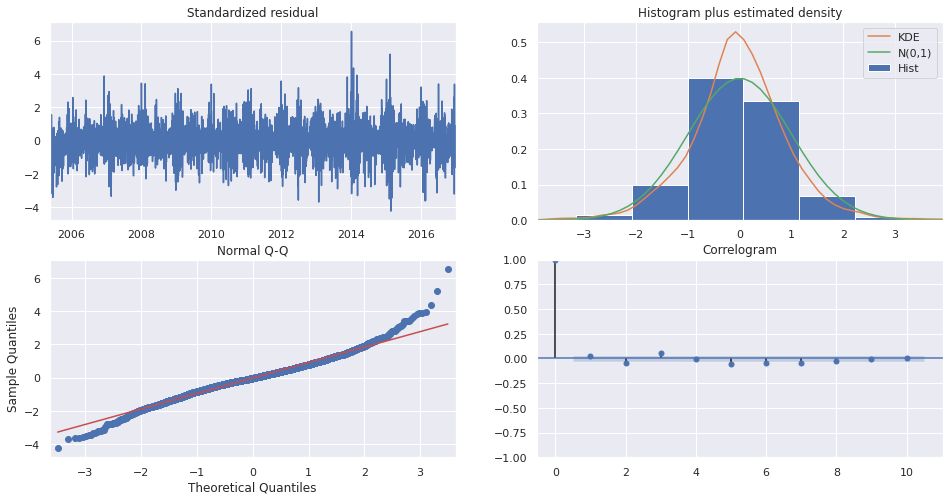

In [ ]:
#ARIMA(2, 1, 1)x(2, 0, 2, 7) - AIC:95250.32397693206

mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(2, 1, 1),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

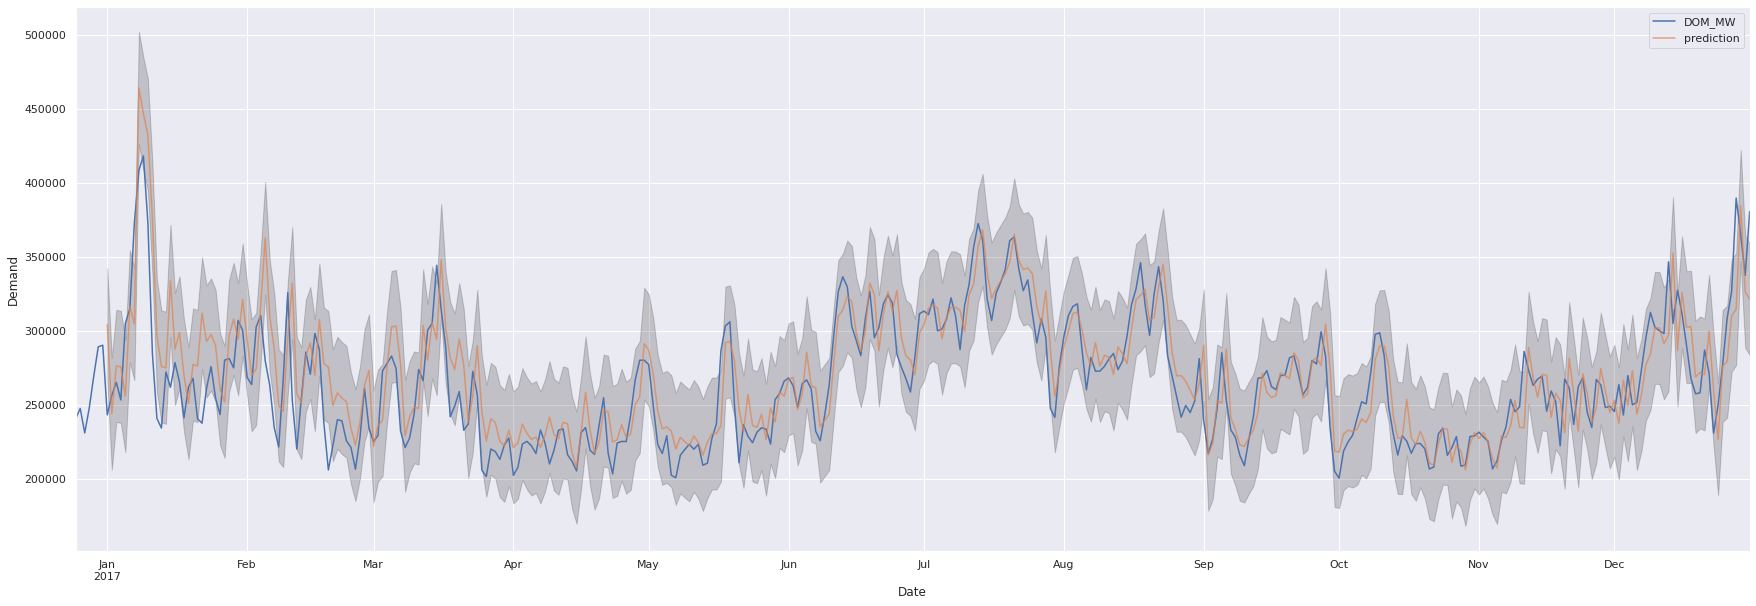

6.522195804702879

In [ ]:
mod = sm.tsa.statespace.SARIMAX(valDay,
                                order=(2, 1, 1),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=val_start, end=val_end, dynamic=False)
pred_ci = pred.conf_int()
ax = valDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(valDay['2017']['DOM_MW'],pred.predicted_mean)
Error

##5.- (1,1,2)x(2,0,1,7)

95266.34894315715
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(1, 1, 2)x(2, 0, 1, 7)   Log Likelihood              -47626.174
Date:                           Sun, 09 Aug 2020   AIC                          95266.349
Time:                                   20:02:43   BIC                          95310.825
Sample:                               05-02-2005   HQIC                         95282.067
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4231      0.024     17.620      0.000       0.376       0.470
ma.L1         -0.3300    

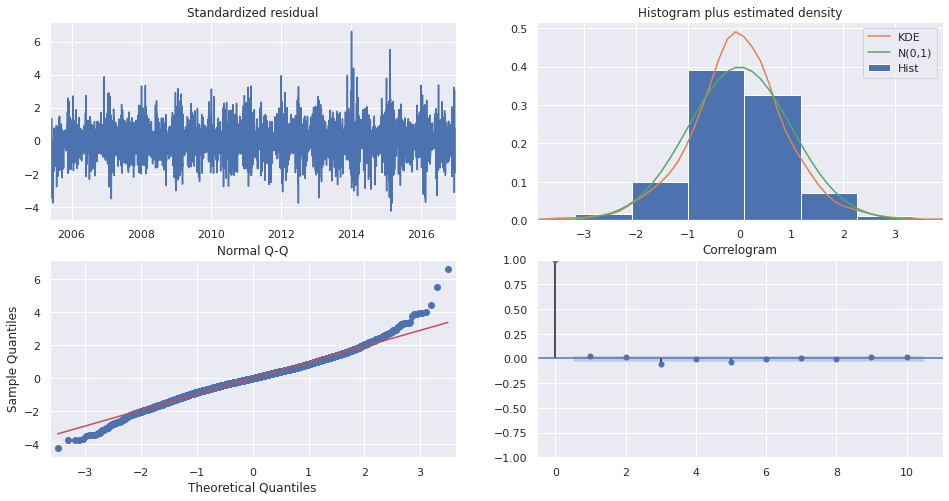

In [ ]:
#ARIMA(1, 1, 2)x(2, 0, 1, 7) - AIC:95266.34894315715

mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(1, 1, 2),
                                seasonal_order=(2, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

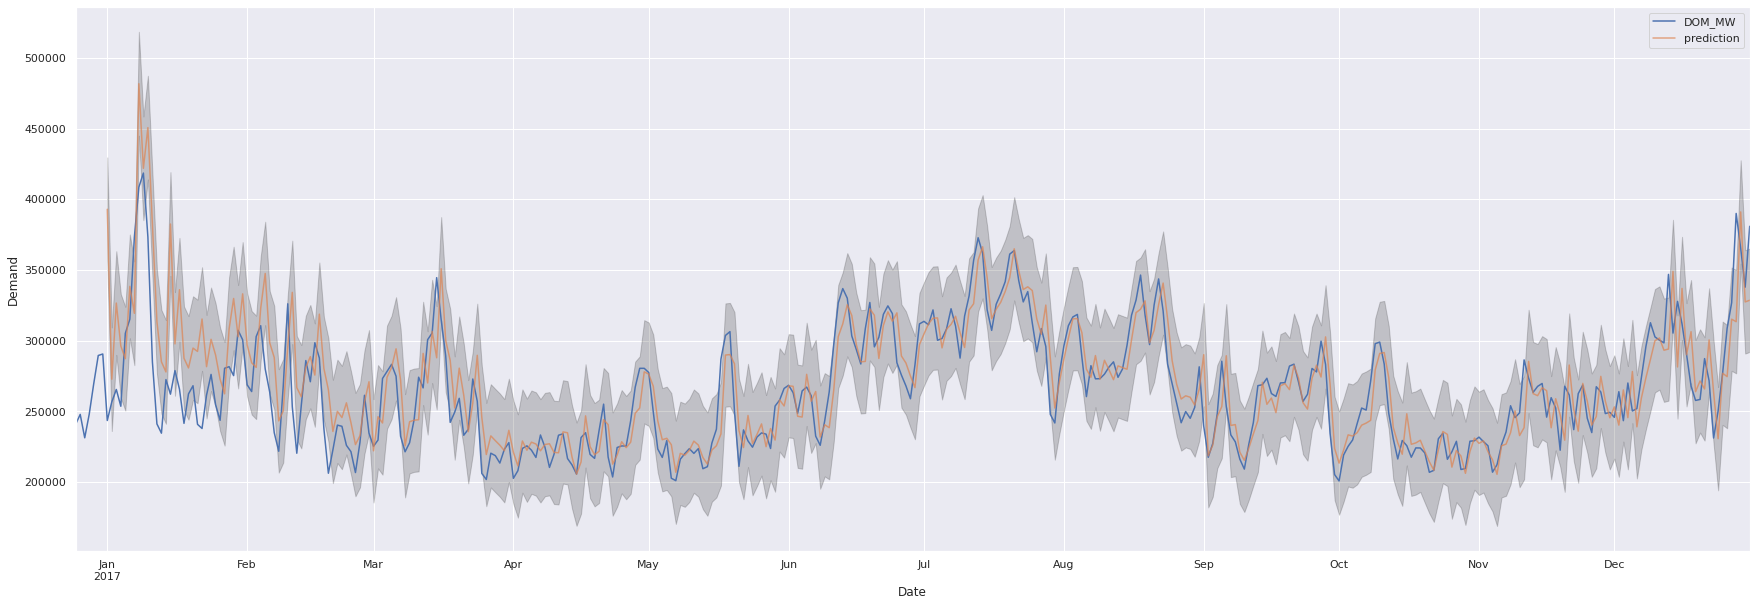

6.522573902367442

In [ ]:
mod = sm.tsa.statespace.SARIMAX(valDay,
                                order=(1, 1, 2),
                                seasonal_order=(2, 0, 1, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=val_start, end=val_end, dynamic=False)
pred_ci = pred.conf_int()
ax = valDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(valDay['2017']['DOM_MW'],pred.predicted_mean)
Error

##6.- (1,1,2)x(1,0,2,7)

95220.40131907877
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(1, 1, 2)x(1, 0, 2, 7)   Log Likelihood              -47603.201
Date:                           Sun, 09 Aug 2020   AIC                          95220.401
Time:                                   20:04:04   BIC                          95264.874
Sample:                               05-02-2005   HQIC                         95236.118
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4390      0.024     18.547      0.000       0.393       0.485
ma.L1         -0.3472    

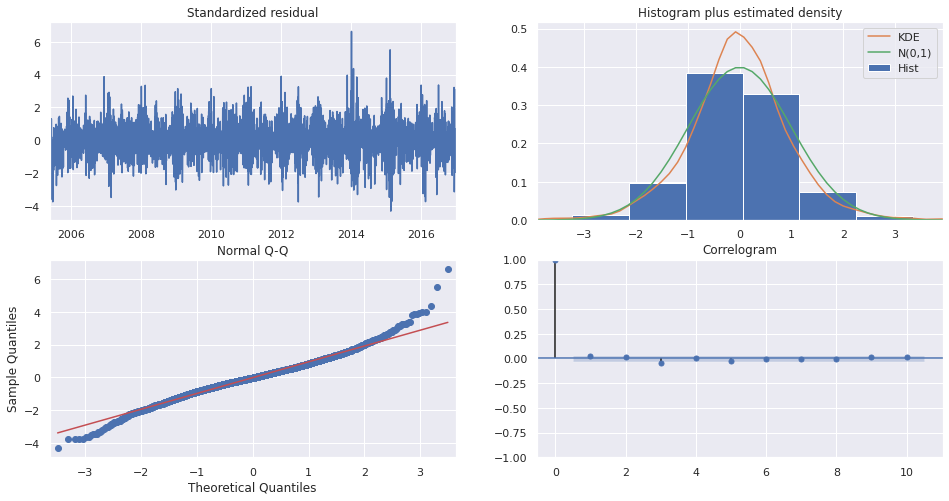

In [ ]:
#ARIMA(2, 1, 0)x(2, 0, 2, 7) - AIC:95353.2282487708

mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

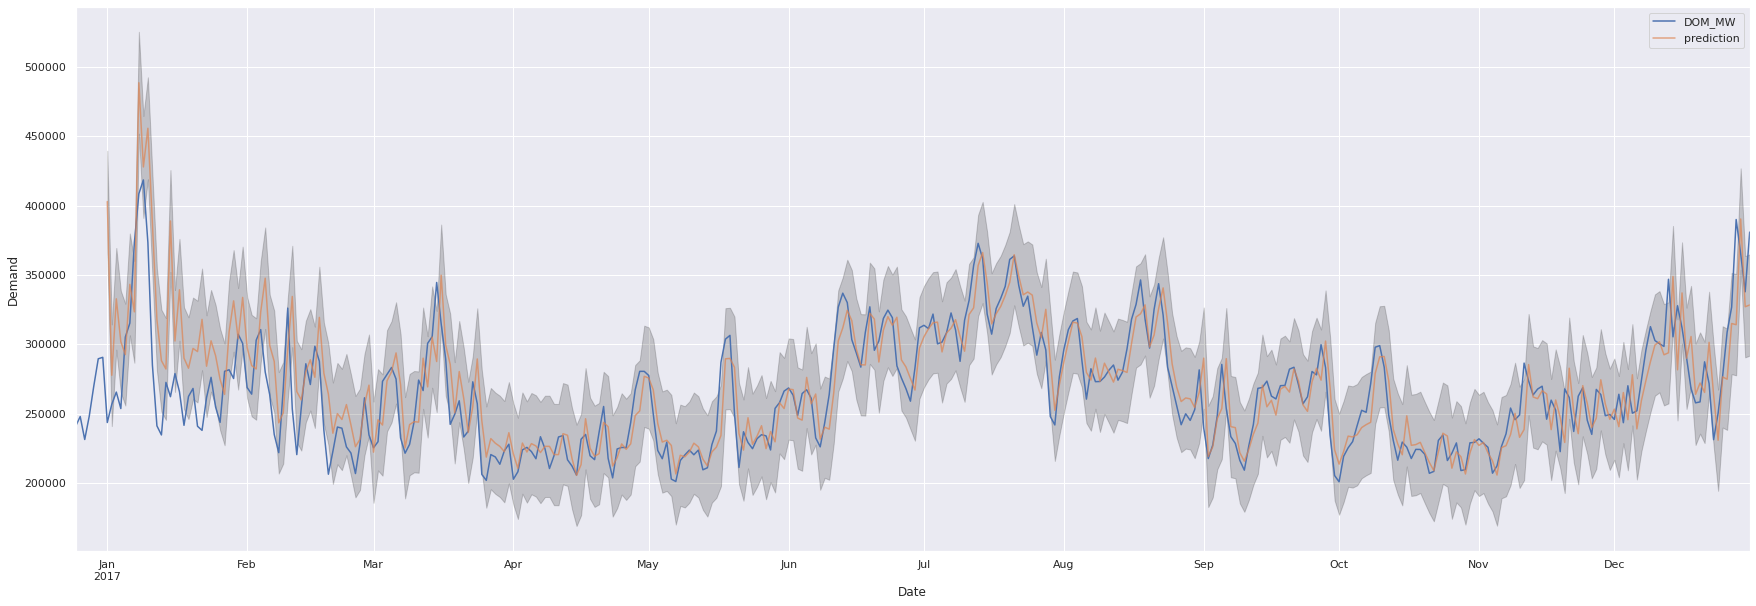

6.595448964125483

In [ ]:
mod = sm.tsa.statespace.SARIMAX(valDay,
                                order=(1, 1, 2),
                                seasonal_order=(1, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=val_start, end=val_end, dynamic=False)
pred_ci = pred.conf_int()
ax = valDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(valDay['2017']['DOM_MW'],pred.predicted_mean)
Error

In [ ]:
#1.- ARIMA(1, 1, 2)x(2, 0, 2, 7) - AIC:95159.45498195656
#2.- ARIMA(2, 1, 2)x(1, 0, 2, 7) - AIC:95204.9510215038
#3.- ARIMA(2, 1, 1)x(2, 0, 1, 7) - AIC:95292.79370698147
#4.- ARIMA(2, 1, 1)x(2, 0, 2, 7) - AIC:95250.32397693206
#5.- ARIMA(1, 1, 2)x(2, 0, 1, 7) - AIC:95266.34894315715
#6.- ARIMA(1, 1, 2)x(1, 0, 2, 7) - AIC:95220.40131907877
#7.- ARIMA(2, 1, 1)x(1, 0, 2, 7) - AIC:95302.69762976833
#8.- ARIMA(2, 1, 0)x(2, 0, 2, 7) - AIC:95353.2282487708

##7.-(2, 1, 1)x(1, 0, 2, 7)

95302.69762976833
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(2, 1, 1)x(1, 0, 2, 7)   Log Likelihood              -47644.349
Date:                           Sun, 09 Aug 2020   AIC                          95302.698
Time:                                   20:05:58   BIC                          95347.172
Sample:                               05-02-2005   HQIC                         95318.415
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7725      0.021     36.062      0.000       0.730       0.814
ar.L2         -0.3686    

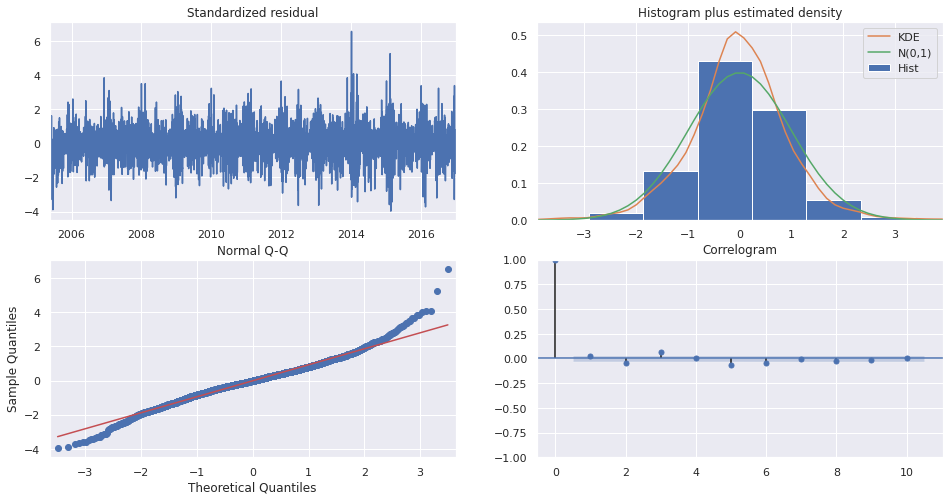

In [ ]:
#ARIMA(2, 1, 1)x(2, 0, 2, 7) - AIC:95250.32397693206

mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(2, 1, 1),
                                seasonal_order=(1, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

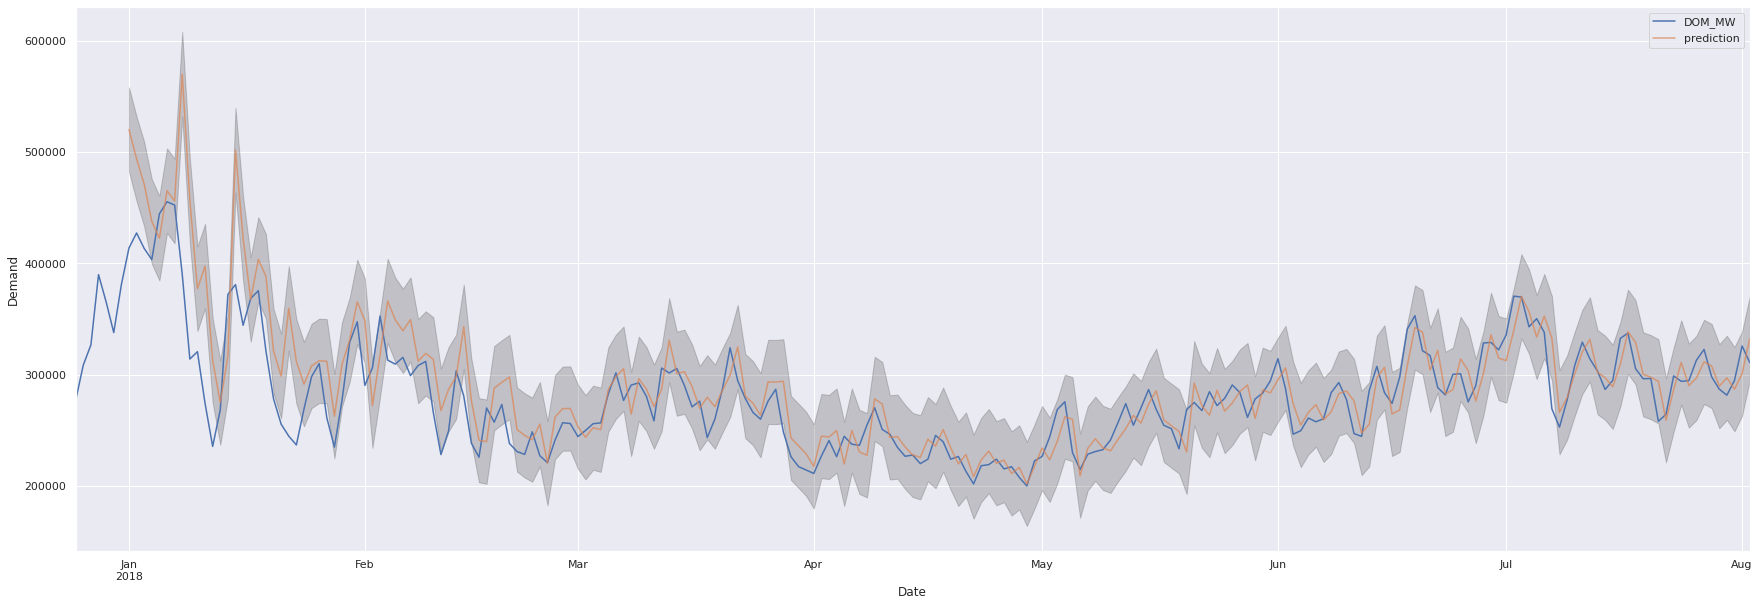

7.533617343329175

In [ ]:
mod = sm.tsa.statespace.SARIMAX(testDay,
                                order=(2, 1, 1),
                                seasonal_order=(1, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=tes_start, end=tes_end, dynamic=False)
pred_ci = pred.conf_int()
ax = testDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(testDay['2018']['DOM_MW'],pred.predicted_mean)
Error

##8.-(2, 1, 0)x(2, 0, 2, 7)

95353.2282487708
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(2, 1, 0)x(2, 0, 2, 7)   Log Likelihood              -47669.614
Date:                           Sun, 09 Aug 2020   AIC                          95353.228
Time:                                   20:13:19   BIC                          95397.703
Sample:                               05-02-2005   HQIC                         95368.946
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1953      0.013     14.753      0.000       0.169       0.221
ar.L2         -0.3059     

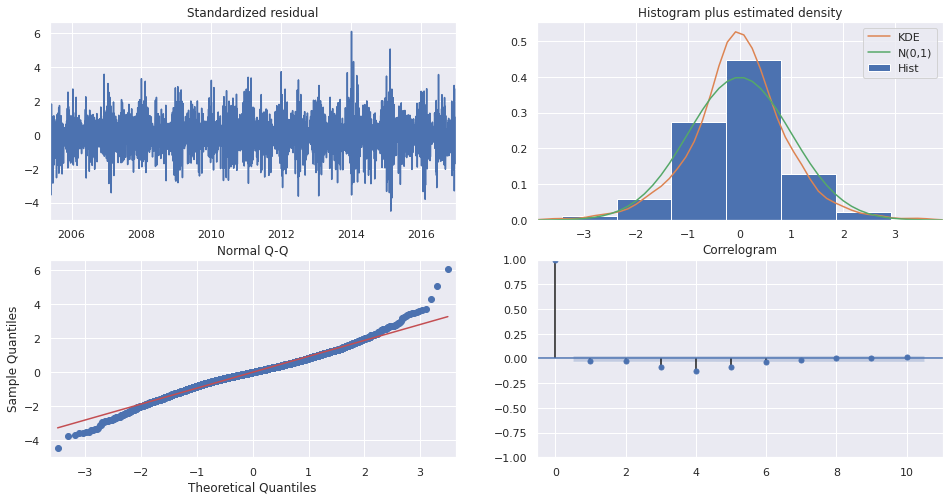

In [ ]:
#ARIMA(2, 1, 0)x(2, 0, 2, 7) - AIC:95250.32397693206

mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(2, 1, 0),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

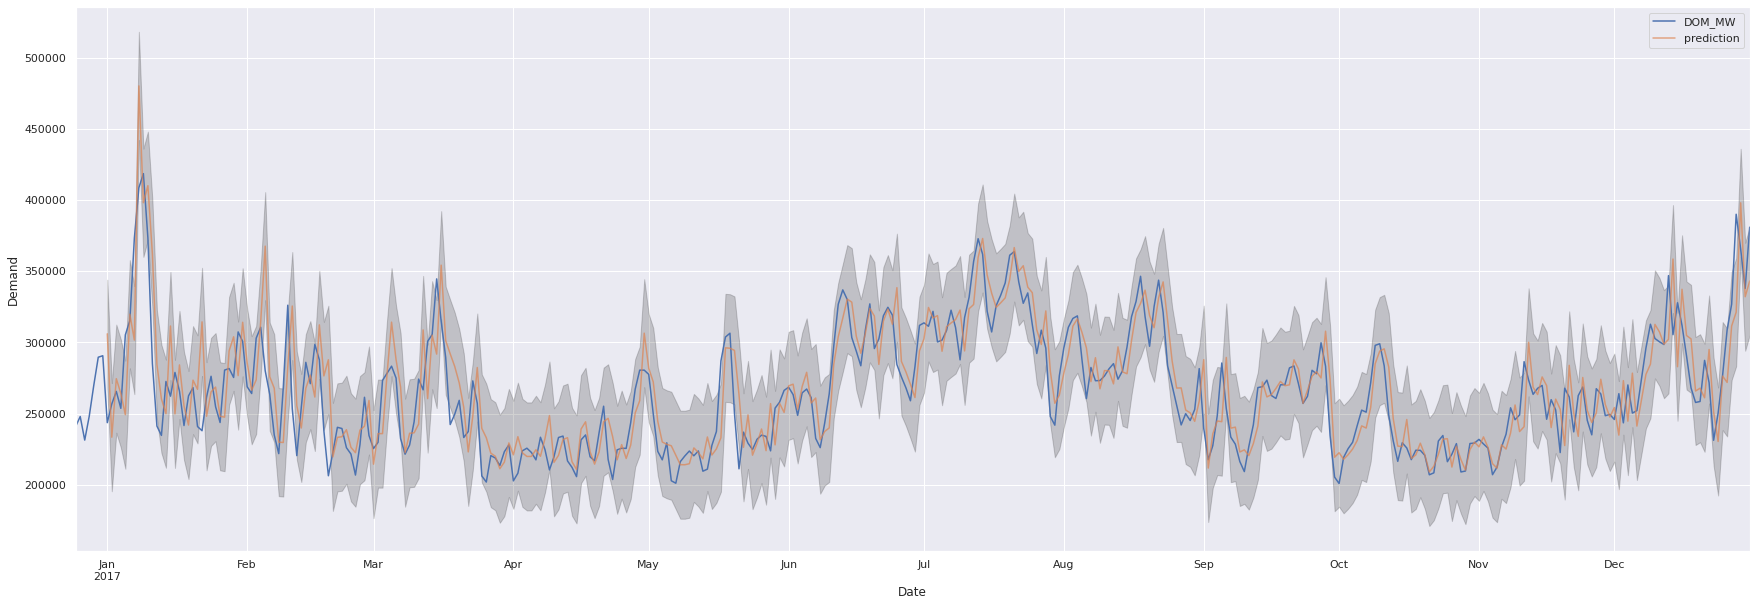

6.37422945816049

In [ ]:
mod = sm.tsa.statespace.SARIMAX(valDay,
                                order=(2, 1, 0),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=val_start, end=val_end, dynamic=False)
pred_ci = pred.conf_int()
ax = valDay.plot(label='observed',figsize=(30,10))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
#ax.set_xlim(left=pd.to_datetime('2017-12-03'), right = pd.to_datetime('2018-07-20'))
plt.legend()
plt.show()


Error = MAPE(valDay['2017']['DOM_MW'],pred.predicted_mean)
Error

##Se observa que el modelo (2, 1, 0)x(2, 0, 2, 7) logra un menor valor de MAPE, por lo tanto se ocuparán dichos hiperparámetros. 

95353.2282487708
                                 Statespace Model Results                                
Dep. Variable:                            DOM_MW   No. Observations:                 4262
Model:             SARIMAX(2, 1, 0)x(2, 0, 2, 7)   Log Likelihood              -47669.614
Date:                           Mon, 17 Aug 2020   AIC                          95353.228
Time:                                   06:12:24   BIC                          95397.703
Sample:                               05-02-2005   HQIC                         95368.946
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1953      0.013     14.753      0.000       0.169       0.221
ar.L2         -0.3059     

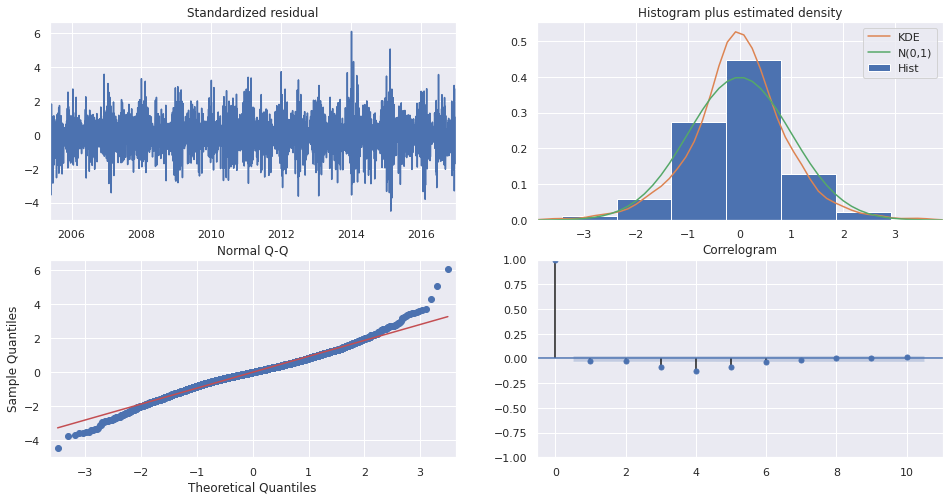

In [ ]:



mod = sm.tsa.statespace.SARIMAX(trainDay,
                                order=(2, 1, 0),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
fit_res = mod.fit(disp=False)
print(fit_res.aic)
print(fit_res.summary())
fit_res.plot_diagnostics(figsize=(16, 8))
plt.show()
#predicción a un paso

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6.935907561739131

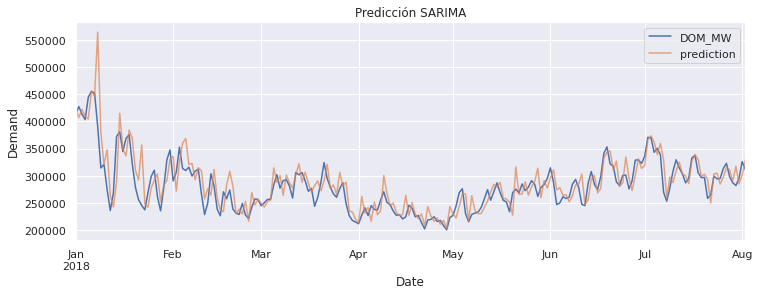

In [ ]:

mod = sm.tsa.statespace.SARIMAX(testDay,
                                order=(2, 1, 0),
                                seasonal_order=(2, 0, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                freq = 'D')
res = mod.filter(fit_res.params)

pred = res.get_prediction(start=tes_start, end=tes_end, dynamic=False)
pred_ci = pred.conf_int()
ax = testDay.plot(label='observed',figsize=(12,4))
pred.predicted_mean.plot(ax=ax, alpha=0.7, label="prediction")
#quitaremos el plot del intervalo de confianza

#ax.fill_between(pred_ci.index,
#                pred_ci.iloc[:, 0],
#                pred_ci.iloc[:, 1], color='k', alpha=0)
ax.set_xlabel('Date')
ax.set_ylabel('Demand')
plt.title('Predicción SARIMA')
ax.set_xlim(left=pd.to_datetime('2018-01-01'))
plt.legend()
#plt.show()

plt.savefig("SARIMA.eps")
files.download("SARIMA.eps")

Error = MAPE(testDay['2018']['DOM_MW'],pred.predicted_mean)
Error

## MAPE = 6.33% para val y 6.93% para test

In [ ]:
#1.- ARIMA(1, 1, 2)x(2, 0, 2, 7) - AIC:95159.45498195656
#2.- ARIMA(2, 1, 2)x(1, 0, 2, 7) - AIC:95204.9510215038
#3.- ARIMA(2, 1, 1)x(2, 0, 1, 7) - AIC:95292.79370698147
#4.- ARIMA(2, 1, 1)x(2, 0, 2, 7) - AIC:95250.32397693206
#5.- ARIMA(1, 1, 2)x(2, 0, 1, 7) - AIC:95266.34894315715
#6.- ARIMA(1, 1, 2)x(1, 0, 2, 7) - AIC:95220.40131907877
#7.- ARIMA(2, 1, 1)x(1, 0, 2, 7) - AIC:95302.69762976833
#8.- ARIMA(2, 1, 0)x(2, 0, 2, 7) - AIC:95353.2282487708

#6.538602324073092
#6.596291720723863
#6.582602043043861
#6.522195804702879
#6.522573902367442
#6.595448964125483
#7.533617343329175
#6.37422945816049